Although my initial study was pretty decent, I would like some more recent verificatiion, maybe even try and throw these models at the pandemic period.

In [35]:
# Imports

import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers


from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

import itertools

%matplotlib inline

In [4]:
# Step 1 is to set the correct range for the data you want it to process
TRAIN_START = '2009-01-01'
TRAIN_END = '2021-07-01'
TEST_START = '2021-07-01'
TEST_END = '2023-05-01'

# Grabbing the dasta from yahoo finance
df_raw = YahooDownloader(start_date=TRAIN_START,
                         end_date=TEST_END,
                         ticker_list=config_tickers.DOW_30_TICKER
                        ).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df_raw

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.422932,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.308598,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941090,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.408859,7117200,CAT,4
...,...,...,...,...,...,...,...,...
105576,2023-04-28,488.690002,493.959991,488.119995,492.089996,2398400,UNH,4
105577,2023-04-28,228.649994,233.570007,228.059998,232.277145,11627900,V,4
105578,2023-04-28,38.560001,39.000000,38.459999,38.830002,19194400,VZ,4
105579,2023-04-28,35.139999,35.380001,34.959999,34.721909,11878500,WBA,4


These will be the technical indicators we use for our machine

In [8]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [9]:
# Next we do some data prep, using built-ins of course
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)

df_processed = fe.preprocess_data(df_raw)
df_processed.head()

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3604, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,2.754725,2.754725,39.189999,0.0
1,2009-01-02,58.590000,59.080002,57.750000,43.422932,6547900,AMGN,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,43.422932,43.422932,39.189999,0.0
2,2009-01-02,18.570000,19.520000,18.400000,15.308598,10955700,AXP,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,15.308598,15.308598,39.189999,0.0
3,2009-01-02,42.799999,45.560001,42.779999,33.941090,7010200,BA,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,33.941090,33.941090,39.189999,0.0
4,2009-01-02,44.910000,46.980000,44.709999,31.408859,7117200,CAT,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,31.408859,31.408859,39.189999,0.0


In [10]:
# Now for the boilerplate code talked about in the intial study
list_ticker = df_processed['tic'].unique().tolist()
list_date = list(pd.date_range(df_processed['date'].min(), df_processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

In [11]:
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(df_processed, on=["date","tic"], how="left")
processed_full = processed_full[processed_full['date'].isin(df_processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754725,746015200.0,4.0,0.000000,2.977272,2.648438,100.000000,66.666667,100.000000,2.754725,2.754725,39.189999,0.000000
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422932,6547900.0,4.0,0.000000,2.977272,2.648438,100.000000,66.666667,100.000000,43.422932,43.422932,39.189999,0.000000
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.308598,10955700.0,4.0,0.000000,2.977272,2.648438,100.000000,66.666667,100.000000,15.308598,15.308598,39.189999,0.000000
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941090,7010200.0,4.0,0.000000,2.977272,2.648438,100.000000,66.666667,100.000000,33.941090,33.941090,39.189999,0.000000
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.408859,7117200.0,4.0,0.000000,2.977272,2.648438,100.000000,66.666667,100.000000,31.408859,31.408859,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151636,2023-04-27,UNH,482.200012,490.980011,482.200012,490.470001,2473200.0,3.0,0.953118,531.227646,465.680356,49.846672,-10.862323,5.922396,490.338332,484.629329,17.030001,48.223586
151637,2023-04-27,V,228.669998,229.630005,226.610001,228.564392,7128200.0,3.0,1.988247,236.272077,222.418667,54.153809,27.347515,4.300545,226.222294,224.769116,17.030001,48.223586
151638,2023-04-27,VZ,37.200001,38.810001,37.130001,38.790001,28841000.0,3.0,-0.079891,40.377515,36.719529,52.791330,4.659338,1.673124,38.008956,38.252595,17.030001,48.223586
151639,2023-04-27,WBA,34.860001,35.200001,34.820000,34.574158,6040500.0,3.0,0.113745,35.927178,33.901785,49.417477,23.682676,2.700258,34.160449,34.571471,17.030001,48.223586


In [12]:
# Perfect, now we split our data into train and test
df_train = data_split(processed_full, TRAIN_START, TRAIN_END)
df_test = data_split(processed_full, TEST_START, TEST_END)

print(len(df_train))
print(len(df_test))

91205
13311


In [14]:
# Alright, now we just need to load our models and run the evals, since the td3 performed the best we will use that one
# first we set up our environment
stock_dim = len(df_train.tic.unique())
state_space = 1 + 2 * stock_dim + len(INDICATORS) * stock_dim
print(f"Stock Dimension: {stock_dim}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [15]:
buy_cost_list = sell_cost_list = [0.001] * stock_dim # The cost of purchasing
num_stock_shares = [0] * stock_dim # Initial stock allocation (ie. we start with owning only cash)

env_kwargs = {
    'hmax': 100, # Number of shares allowed to buy or sell at any given step
    'initial_amount': 1_000,
    'num_stock_shares': num_stock_shares,
    'buy_cost_pct': buy_cost_list,
    'sell_cost_pct': sell_cost_list,
    'state_space': state_space,
    'stock_dim': stock_dim,
    'tech_indicator_list': INDICATORS,
    'action_space': stock_dim,
    'reward_scaling': 1e-4
}

e_test_gym = StockTradingEnv(
    df = df_test,
    turbulence_threshold=70,
    risk_indicator_col='vix',
    **env_kwargs
)

In [16]:
# Now that we have set up our environment, we now load our model and test it
from stable_baselines3 import TD3

trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")

In [17]:
df_acc_val_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment=e_test_gym
)

hit end!


In [19]:
df_acc_val_td3 = df_acc_val_td3.set_index('date')
df_acc_val_td3.columns=['TD3']

In [41]:
df_acc_val_td3

,TD3
date,
2021-07-01,1000.000000
2021-07-02,1004.810298
2021-07-06,1003.125689
2021-07-07,1001.830798
2021-07-08,1001.016467
...,...
2023-04-21,1108.487937
2023-04-24,1116.030692
2023-04-25,1107.432292


In [18]:
from plotnine import *

In [28]:
df_results_plot

,date,variable,value
0,2021-07-01,TD3,1000.000000
1,2021-07-02,TD3,1004.810298
2,2021-07-06,TD3,1003.125689
3,2021-07-07,TD3,1001.830798
4,2021-07-08,TD3,1001.016467
...,...,...,...
454,2023-04-21,TD3,1108.487937
455,2023-04-24,TD3,1116.030692
456,2023-04-25,TD3,1107.432292
457,2023-04-26,TD3,1102.279784


<AxesSubplot: xlabel='date'>

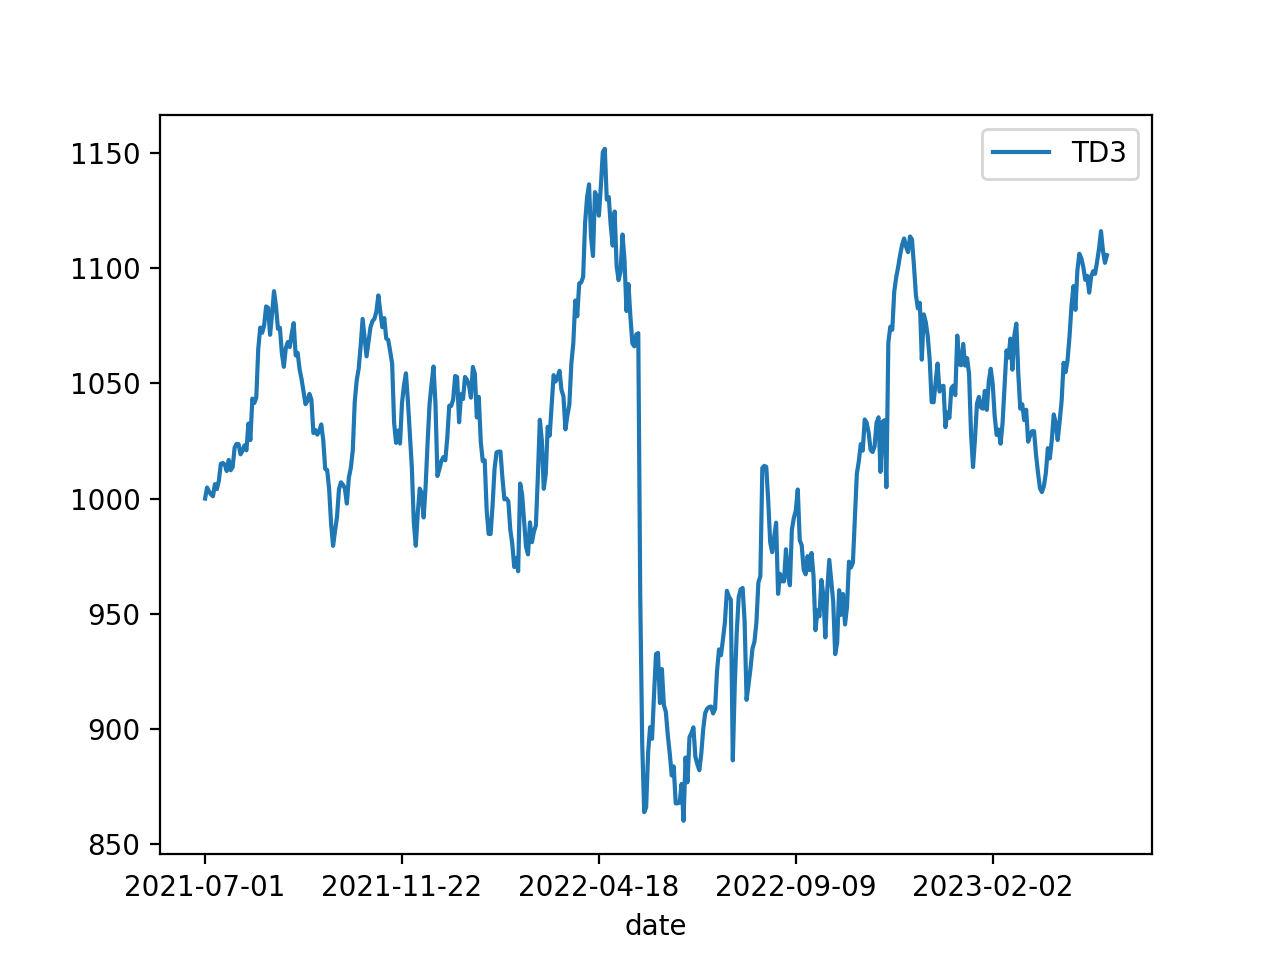

In [45]:
df_results_plot = df_acc_val_td3.reset_index().melt(id_vars='date')

# Drawing the plot
df_acc_val_td3.plot()

In [46]:
df_actions_td3

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
2021-07-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-07-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-04-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2023-04-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
